# Poincaré sections of experimental EEG data

## Poincaré section of the delay embedding plot

In [1]:
from IPython.display import Image,display,HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



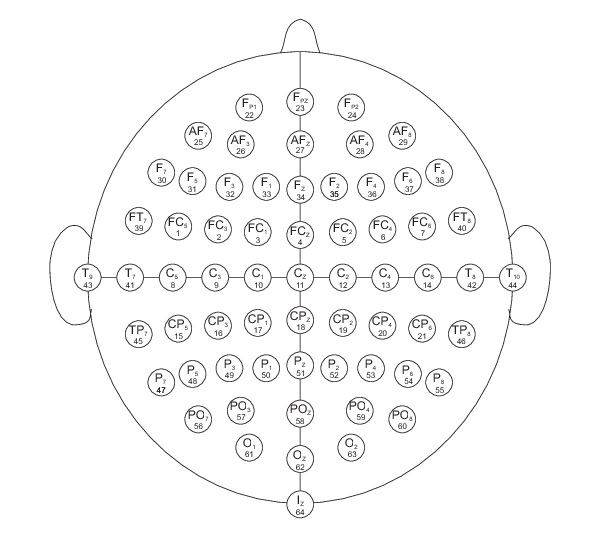

In [2]:
Image("../64_channel_sharbrough.png",width=700,height=700)

Text(0,0.5,'EEG Site')

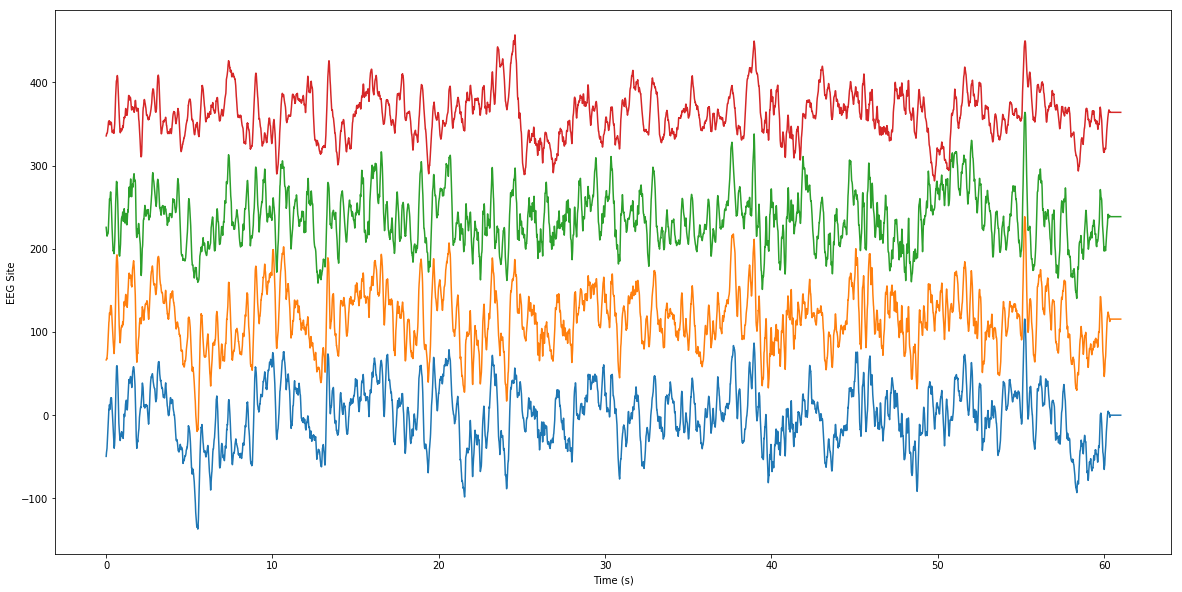

In [143]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

A = np.loadtxt('../Eyes_closed/S001/S001R02_data_smoothed.txt',delimiter=',',skiprows=1,unpack=True)
fig,ax = plt.subplots(1,1)
fig.set_figheight(10)
fig.set_figwidth(20)
ax.plot(A[0],A[1])
ax.plot(A[0],A[2]+max(A[1]))
ax.plot(A[0],A[20]+max(A[2])+max(A[1]))
ax.plot(A[0],A[40]+max(A[20])+max(A[2])+max(A[1]))
ax.set_xlabel('Time (s)')
ax.set_ylabel('EEG Site')

## Poincaré section of the maxima

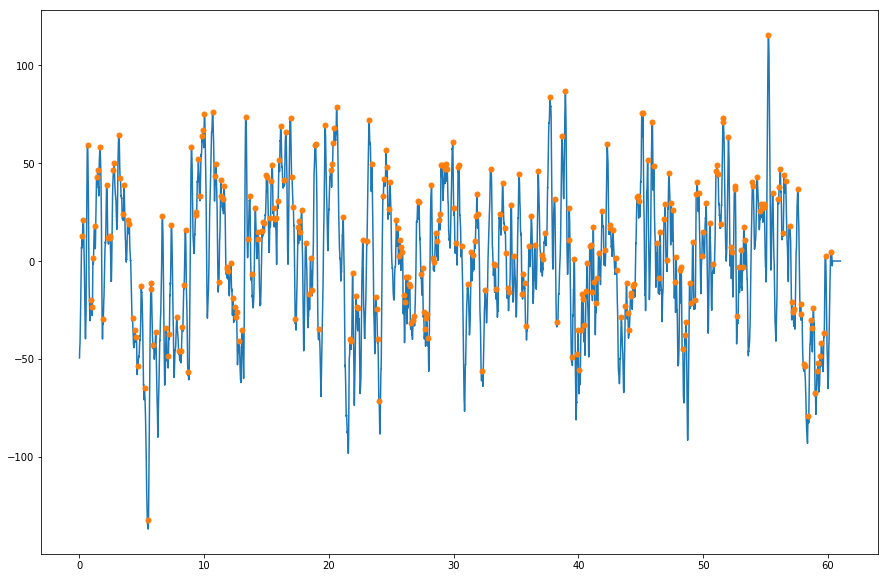

In [145]:
D = np.loadtxt('../Eyes_closed/S001/Peaks.dat',unpack=True)
fig,ax = plt.subplots(1,1)
fig.set_figheight(10)
fig.set_figwidth(15)
ax.plot(A[0],A[1])
ax.plot(D[0],D[1],'.',ms=10)

Text(13.5039,56,'local max')

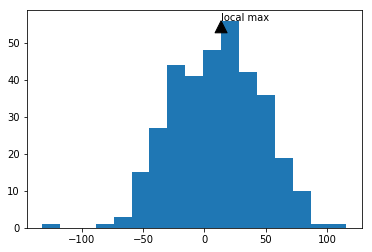

In [146]:


histogram = plt.hist(D[1],bins='auto')
x = histogram[1][list(histogram[0]).index(max(histogram[0]))]
y = max(histogram[0])
plt.annotate('local max', xy=(x, y),
            xytext=(x, y),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )



In [147]:
def ent(data):
    from scipy.stats import entropy
    import pandas as pd
    df = pd.DataFrame({'time':data})
    p_data= df['time'].value_counts()/len(df['time']) # calculates the probabilities
    entropy=entropy(p_data)  # input probabilities to get the entropy 
    return entropy

In [160]:
New_array = D[0][(D[1]>=-50) & (D[1] <= 50)]
ent(New_array)

5.693732138802701

4.6168605171904105

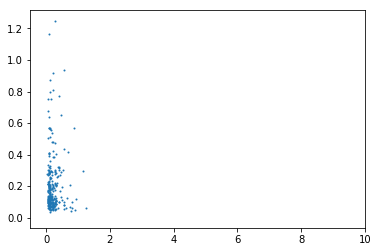

In [161]:
section = []
for l in range(len(New_array)):
    if(New_array[l]-New_array[l-1]>=0.0):
        New_array[-2]=0.0
        New_array[-1]=0.0
        section.append((New_array[l-1]-New_array[l-2],New_array[l]-New_array[l-1]))
        
plt.scatter(*zip(*section),s=1)
plt.xlim([-0.5,10])
ent(zip(*section)[1])

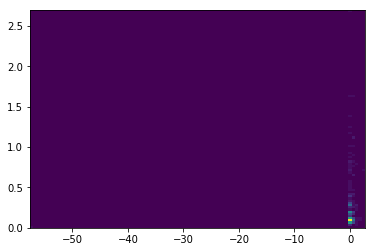

In [159]:

hist_2 = plt.hist2d(*zip(*section),bins=100)
#plt.tight_layout()


### Fitting multivariate functions

In [14]:
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate


def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)


def kde_statsmodels_u(x, x_grid, bandwidth=0.2, **kwargs):
    """Univariate Kernel Density Estimation with Statsmodels"""
    kde = KDEUnivariate(x)
    kde.fit(bw=bandwidth, **kwargs)
    return kde.evaluate(x_grid)
    
    
def kde_statsmodels_m(x, x_grid, bandwidth=0.2, **kwargs):
    """Multivariate Kernel Density Estimation with Statsmodels"""
    kde = KDEMultivariate(x, bw=bandwidth * np.ones_like(x),
                          var_type='c', **kwargs)
    return kde.pdf(x_grid)


def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)


kde_funcs = [kde_statsmodels_u, kde_statsmodels_m, kde_scipy, kde_sklearn]
kde_funcnames = ['Statsmodels-U', 'Statsmodels-M', 'Scipy', 'Scikit-learn']

print "Package Versions:"
import sklearn; print "  scikit-learn:", sklearn.__version__
import scipy; print "  scipy:", scipy.__version__
import statsmodels; print "  statsmodels:", statsmodels.__version__

Package Versions:
  scikit-learn: 0.19.1
  scipy: 1.1.0
  statsmodels: 0.9.0


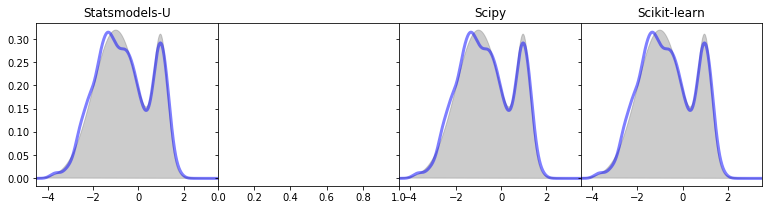

In [63]:
from scipy.stats.distributions import norm

# The grid we'll use for plotting
x_grid = np.linspace(-4.5, 3.5, 1000)

# Draw points from a bimodal distribution in 1D
np.random.seed(0)
x = np.concatenate([norm(-1, 1.).rvs(400),
                    norm(1, 0.3).rvs(100)])
pdf_true = (0.8 * norm(-1, 1).pdf(x_grid) +
            0.2 * norm(1, 0.3).pdf(x_grid))

# Plot the three kernel density estimates
fig, ax = plt.subplots(1, 4, sharey=True,
                       figsize=(13, 3))
fig.subplots_adjust(wspace=0)

for i in [0,2,3]:
    pdf = kde_funcs[i](x, x_grid, bandwidth=0.2)
    ax[i].plot(x_grid, pdf, color='blue', alpha=0.5, lw=3)
    ax[i].fill(x_grid, pdf_true, ec='gray', fc='gray', alpha=0.4)
    ax[i].set_title(kde_funcnames[i])
    ax[i].set_xlim(-4.5, 3.5)
    
from IPython.display import HTML
HTML("<font color='#666666'>Gray = True underlying distribution</font><br>"
     "<font color='6666ff'>Blue = KDE model distribution (500 pts)</font>")



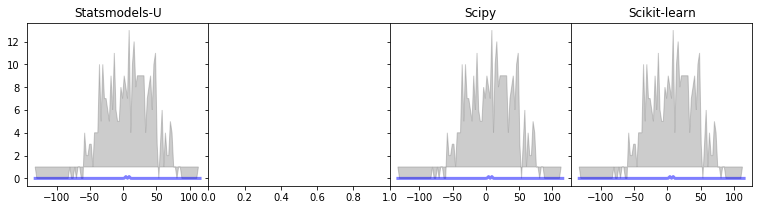

In [85]:
# Plot the three kernel density estimates
fig, ax = plt.subplots(1, 4, sharey=True,
                       figsize=(13, 3))
fig.subplots_adjust(wspace=0)

for i in [0,2,3]:
    pdf = kde_funcs[i](histogram[0], histogram[1], bandwidth=0.2)
    ax[i].plot(histogram[1], pdf, color='blue', alpha=0.5, lw=3)
    ax[i].fill(histogram[1][:-1],histogram[0] , ec='gray', fc='gray', alpha=0.4)
    ax[i].set_title(kde_funcnames[i])
    #ax[i].set_xlim(-4.5, 3.5)

In [ ]:

C = np.loadtxt('../Eyes_closed/S001/Poincare_Section_3D_Delay_10.00.dat',unpack=True)

mlab.figure(bgcolor=gray)
# creating volume that increases in value
s=np.ones(len(C[0]))
mlab.points3d(C[0],C[1],C[2],0.1*s,scale_factor=.05,color=black)
mlab.outline()
#mlab.show()

## Model

Can we retrieve an underlying deterministic source of complex dynamics from the irregular dynamics of a system of coupled cortical columns? The question would be, is the topology of the brain shaping the information processing capacity of itself? 
Below is a representation of a 2D attractor, in which the x and y axis represent the interpulse intervals with which cortical columns will be fed.

In [ ]:
Image("Zavs_rec.png",width=500,height=500)

In [ ]:
Image("Henon_rec.png",width=500,height=500)

In [ ]:
Image("Chen_rec.png",width=500,height=500)


In this simulations a system of coupled cortical columns, with a connectivity defined by the constructed connectome from an individual, receives pulsed inputs with timings that embed information. The timings come from different deterministic sources (chaotic attractors) which are complex and can be represented in a 2-dimensional space. We have explored the **Poincaré section** of the **delay embedding** plot. The selection of that section is crucial so as to discern between pure noisy, periodic (trivial) or complex (chaotic) information processing.


In [ ]:
Image("Figure_01_pre-crop.png",width=500,height=500)

In [ ]:
Image("Figure_02_pre-crop.png",width=500,height=500)

For individual cortical columns there is barely any difference of the dynamics evoked by the pulses coming from the attractors, as can be seen from the picture on the right. However, there are more **Poincaré sections** to be explored, whose characteristics might help retrieving the input information.

Below there is a representation of the distributed processing assumed in the modeling: each cortical column receives a train of pulses that embeds different parts of the information contained in the attractors. In this way, parallel processing increases the computational capability of the network, as will be seen later.

In [ ]:
Image("Figure_05_pre-crop.png",width=500,height=500)

Finally, accurate input information is retrieved thanks to the **Poincaré section of the maxima**, which keeps track of the positions of the peaks in time, as can be seen in the figure below.



In [ ]:
Image("Figure_04.png",width=500,height=500)

In simulated topologies, there are regions of the excitatory-inhibitory parameter space where the reconstruction of the input information is higher. Such parameter region is not the trivial uncoupled case, but a complex combination of excitatory and inhibitory couplings instead:

In [ ]:
Image("Figure_06.png",width=800,height=800)

Exploring different excitatory and inhibitory coupling strenghts on can see how the information processing capacity can be dampened, mainly if inhibition dominates over excitation. 

This frame embeds interesting ideas such as the information processing capacity of the brain and its relationship with its topology, altogether taken at the mesoscopic scale. It also reconciles the notion of information processing at the level of synchronized oscillations, as in the simulations one can observe periods of synchronized activity, typical of EEG recordings (see shaded area in the simulated EEG signal).

### Realistic structural connectome 

The first 'information' that is fed into the cortical columns (**cortical regions in the constructed connectome**) is the 2D Poincaré section of the Chen attractor.

In [ ]:
E = np.loadtxt('../../../../UPC/Deterministic_Spatiotemporal_Processing/Real_Brain/Chen/Output_Scale_Free/Output_No_Noise/Output_Clustering_0.5/Output_Time_Scale_1/1_variable/Chen/Output_0001/Output_alpha_08.00/Output_beta_02.00/Data_0155.dat',unpack=True)
fig,ax = plt.subplots(1,1)
fig.set_figheight(10)
fig.set_figwidth(20)
ax.plot(E[0],E[1])
ax.plot(E[0],E[2]+max(E[1]))
ax.plot(E[0],E[20]+max(E[2])+max(E[1]))
ax.plot(E[0],E[40]+max(E[20])+max(E[2])+max(E[1]))
ax.axvspan(19, 20, alpha=0.2, color='red')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Brain Site')
plt.xlim([0.5,51])
plt.ylim([-5,90])

The reconstruction of the information depends on the excitatory and inhibitory couplings in the connectome. For excitation being higher than inhibition the reconstruction is:

In [ ]:
Image("../../../../UPC/Deterministic_Spatiotemporal_Processing/Real_Brain/Chen/Output_Scale_Free/Output_No_Noise/Output_Clustering_0.5/Output_Time_Scale_1/1_variable/Chen/Output_0001/Output_alpha_08.00/Output_beta_02.00/Poincare_Sections.png",width=700,height=700)

whereas for inhibition dominating over excitation the reconstruction is:

In [ ]:
Image("../../../../UPC/Deterministic_Spatiotemporal_Processing/Real_Brain/Chen/Output_Scale_Free/Output_No_Noise/Output_Clustering_0.5/Output_Time_Scale_1/1_variable/Chen/Output_0001/Output_alpha_08.00/Output_beta_32.00/Poincare_Sections.png",width=700,height=700)

In [ ]:
from scipy.signal import butter, lfilter


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [ ]:
"""
Compute the coherence of two signals
"""
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)
# make a little extra space between the subplots
plt.subplots_adjust(wspace=0.5)

nfft = 256/2
dt = 0.01
t = np.arange(0, 5, dt)
nse1 = np.random.randn(len(t))                 # white noise 1
nse2 = np.random.randn(len(t))                 # white noise 2
r = np.exp(-t/0.05)

cnse1 = np.convolve(nse1, r, mode='same')*dt   # colored noise 1
cnse2 = np.convolve(nse2, r, mode='same')*dt   # colored noise 2

# two signals with a coherent part and a random part
s1 = .01*np.sin(2*np.pi*10*t) + cnse1
s2 = .01*np.sin(2*np.pi*10*t) + cnse2

lowcut = .1
highcut = 15
fs = 200
y1 = butter_bandpass_filter(s1, lowcut, highcut, fs, order=6)
y2 = butter_bandpass_filter(s2, lowcut, highcut, fs, order=6)

plt.subplot(211)
plt.plot(t, y1, 'b-', t, y2, 'g-')
plt.xlim(0,5)
plt.xlabel('time')
plt.ylabel('s1 and s2')
plt.grid(True)

plt.subplot(212)
cxy, f = plt.cohere(y2, y1, nfft, 1./dt)
plt.ylabel('coherence')
#plt.show()

In [ ]:

import os
num_columns=2

iterator=[]
#Load data sets
#t = loadtxt(infile, unpack=True,usecols=(0,))
for i in (54,55,25):
    iterator.append(i)

s = np.loadtxt('../Task_1/S001/S001R03_data.txt',unpack=True,delimiter=',',usecols=(iterator),skiprows=1)
s1 = s[0]
s2 = s[1]


lowcut = 8.0
highcut = 15.0
fs = 500
y1 = butter_bandpass_filter(s1, lowcut, highcut, fs, order=6)
y2 = butter_bandpass_filter(s2, lowcut, highcut, fs, order=6)

time = np.genfromtxt('../Task_1/S001/S001R03_data.txt',unpack=True,delimiter=',',usecols=0,skip_header=1)
dt = time[1]-time[0]
plt.subplot(211)
plt.plot(time[:800], y1[:800]-y1[:800].mean(), 'b-', time[:800], y2[:800]-y2[:800].mean(), 'g-')
plt.xlim(0,5)
plt.xlabel('time')
plt.ylabel('s1 and s2')
plt.grid(True)

nfft = int(256./5)


plt.subplot(212)
cxy, f = plt.cohere(y1[:800], y2[:800], nfft, 1./dt)
#cxy, f = plt.cohere(y1[:800]-y1[:800].mean(), y2[:800]-y2[:800].mean(), nfft, 1./dt)
plt.ylabel('coherence')

In [ ]:
plt.subplot(121)
plt.psd(y1, nfft*6, 1./dt)
plt.title('signal1')
plt.xlim([30,50])
plt.subplot(122)
plt.psd(y2, nfft*5, 1./dt)
plt.title('signal2')
plt.tight_layout()
plt.xlim([30,50])

In [ ]:
csdxy, fcsd = plt.csd(s1, s2, nfft, 1./dt)
plt.ylabel('CSD (db)')
plt.title('cross spectral density between signal 1 and 2')
plt.tight_layout()

In [ ]:
# coherence
cxy, fcoh = plt.cohere(s1, s2, nfft, 1./dt)

# calculate 95% confidence level
edof = (len(s1)/(nfft/2)) * cxy.mean() # equivalent degrees of freedom: (length(timeseries)/windowhalfwidth)*mean_coherence
gamma95 = 1.-(0.05)**(1./(edof-1.))
conf95 = np.where(cxy>gamma95)
print 'gamma95',gamma95, 'edof',edof

# Plot twin plot
fig, ax1 = plt.subplots()
# plot on ax1 the coherence
ax1.plot(fcoh, cxy, 'b-')
ax1.set_xlabel('Frequency (hr-1)')
ax1.set_ylim([0,1])
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Coherence', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')

# plot on ax2 the phase
ax2 = ax1.twinx()
ax2.plot(fcoh[conf95], phase[conf95], 'r.')
ax2.set_ylabel('Phase (degrees)', color='r')
ax2.set_ylim([-200,200])
ax2.set_yticklabels([-180,-135,-90,-45,0,45,90,135,180])

for tl in ax2.get_yticklabels():
    tl.set_color('r')

ax1.grid(True)
#ax2.grid(True)
fig.suptitle('Coherence and phase (>95%) between signal 1 and 2', fontsize='12')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz

# Sample rate and desired cutoff frequencies (in Hz).
fs = 5000.0
lowcut = 500.0
highcut = 1250.0

# Plot the frequency response for a few different orders.
plt.figure(1)
plt.clf()
for order in [3, 6, 9]:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')

# Filter a noisy signal.
T = 0.05
nsamples = T * fs
t = np.linspace(0, T, nsamples, endpoint=False)
a = 0.02
f0 = 600.0
x = 0.1 * np.sin(2 * np.pi * 1.2 * np.sqrt(t))
x += 0.01 * np.cos(2 * np.pi * 312 * t + 0.1)
x += a * np.cos(2 * np.pi * f0 * t + .11)
x += 0.03 * np.cos(2 * np.pi * 2000 * t)
plt.figure(2)
plt.clf()
plt.plot(t, x, label='Noisy signal')

y = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)
plt.plot(t, y, label='Filtered signal (%g Hz)' % f0)
plt.xlabel('time (seconds)')
plt.hlines([-a, a], 0, T, linestyles='--')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
pca = PCA(n_components=2)
pca.fit(X)


print(pca.explained_variance_ratio_)  

print(pca.singular_values_)  

In [ ]:
pca = PCA(n_components=2, svd_solver='full')
pca.fit(X)                 


print(pca.explained_variance_ratio_)  

print(pca.singular_values_)  

In [ ]:
pca = PCA(n_components=1, svd_solver='arpack')
pca.fit(X)


print(pca.explained_variance_ratio_)  

print(pca.singular_values_)  

In [ ]:
import numpy as np
from sklearn.decomposition import IncrementalPCA
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
ipca = IncrementalPCA(n_components=2, batch_size=3)
ipca.fit(X)

ipca.transform(X)

In [ ]:
#X = np.array([[0.00148736,0.00099157,0,0.01189886,0.,0.],[0.,0.00198314,0.,0.00049579,0.,0.00049579],[0.,0.00594943,0.,0.00198314,0.,0.00049579],[0.00446207,0.,0.,0.00148736,0.,0.],[0.,0.,0.0034705,0.00049579,0.00198314,0.00495786],[0.,0.,0.04462072,0.,0.00594943,0.00148736]])


pca = PCA(n_components='mle')
pca.fit(X)

print(pca.explained_variance_ratio_)  

print(pca.singular_values_) 

print(pca.n_components_)

In [ ]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
#X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
y = np.array([1, 1, 1, 2, 2, 2]) # 1 corresponds to motor movement, 2 to imagined motor movement
clf = LDA()
clf.fit(X, y)

print clf.predict([[0.0,0.1,0.1,0.1,0.,0.0]])
print clf.predict_proba(X)